In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pynapple as nap
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
from scipy.stats import zscore

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# weird behaviour from this example
mouse = 29
day = 23

In [3]:
mouse = 25
day = 24

session_type = 'VR'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/nwb_data/')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)

if session_type == 'VR':
    tl = 200
elif session_type == 'MCVR':
    tl = 230


In [4]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
ramp_scores = tuning_scores['ramp_class']
bin_config = get_bin_config(session_type)['P']
n_bins = bin_config['num_bins']
bounds = bin_config['bounds']
sigma = bin_config['smooth_sigma']

In [5]:
def make_trial_rate_map(neurons, session, bin_config):
    n_bins = bin_config['num_bins']
    bounds = bin_config['bounds']
    sigma = bin_config['smooth_sigma']

    tcs = {}
    for index in neurons.index:
        this_neuron = neurons[neurons.index == index]
        trial_tcs = []
        for tn in session['trials']['trial_number']:
            trial = session['trials'][session['trials']['trial_number'] == tn]
            tc = nap.compute_1d_tuning_curves(this_neuron, 
                                              session["P"], 
                                              nb_bins=n_bins, 
                                              minmax=[bounds[0], bounds[1]],
                                              ep=session["moving"].intersect(trial))[index]
            tc = np.nan_to_num(tc)
            trial_tcs.append(tc)
        trial_tcs = np.array(trial_tcs)
        trial_tcs_flat = trial_tcs.flatten()
        trial_tcs_flat = gaussian_filter(np.nan_to_num(trial_tcs_flat).astype(np.float64), sigma=sigma)
        trial_tcs = trial_tcs_flat.reshape(trial_tcs.shape)

        tcs[index] = trial_tcs
    return tcs

In [9]:
def avg_rate_maps(trial_tcs):
    avg_rate_maps = {}
    avg_rate_map_sems = {}
    for _, (index, trial_tc) in enumerate(trial_tcs.items()):
        avg_rate_maps[index] = np.nanmean(trial_tc,axis=0)
        avg_rate_map_sems[index] = stats.sem(trial_tc,axis=0, nan_policy='omit')
    return avg_rate_maps, avg_rate_map_sems

In [10]:
trial_tcs = make_trial_rate_map(neurons, session, bin_config)
avg_tcs, avg_tc_sems = avg_rate_maps(trial_tcs)

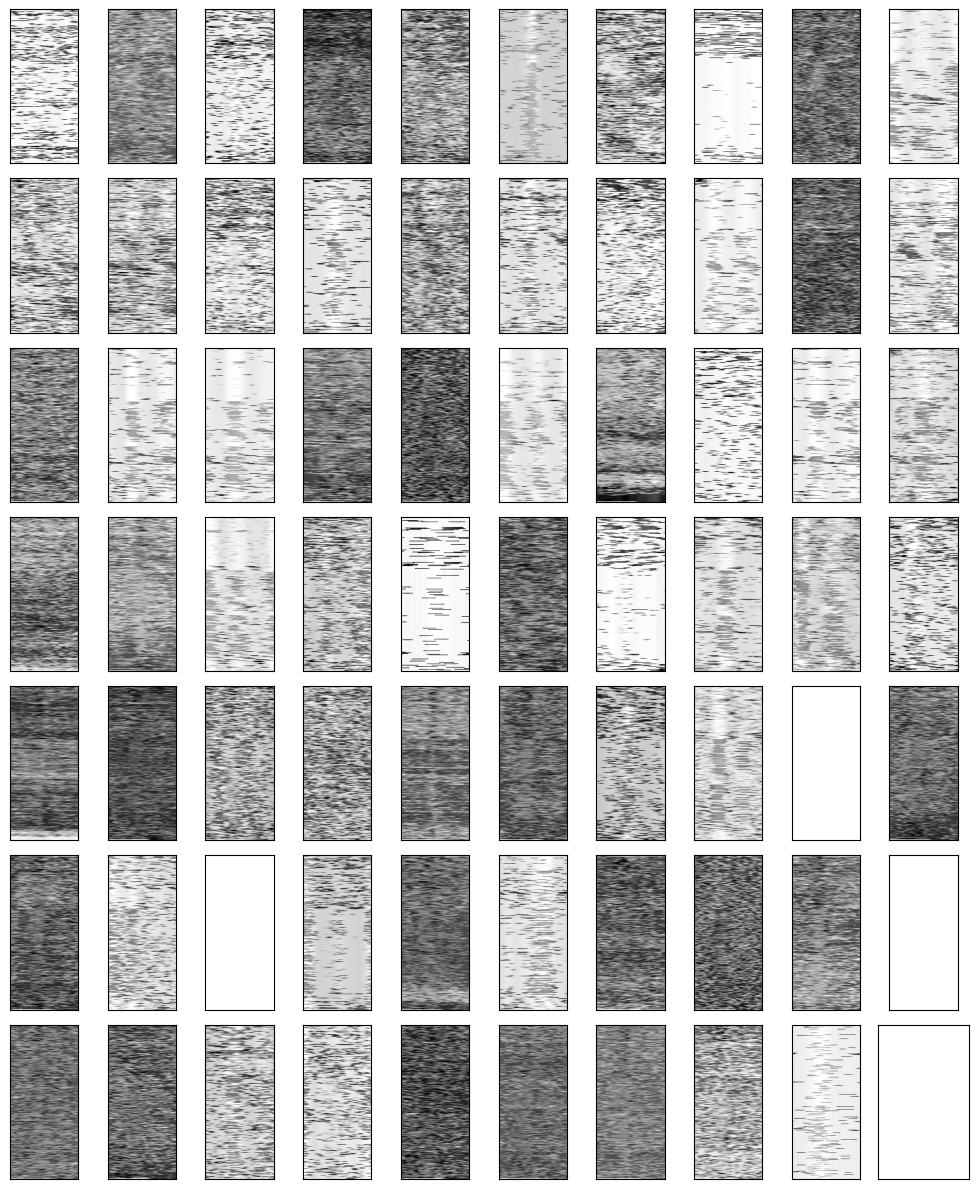

In [15]:
ncols = 10
nrows = int(np.ceil(len(trial_tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 4*(np.ceil(len(trial_tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(trial_tcs):
            index = neurons.index[counter]
            tc = trial_tcs[index]
            tc = np.clip(tc, max=np.nanpercentile(tc, 90))
            ax[j, i].imshow(zscore(tc), cmap='binary')
            ax[j, i].invert_yaxis()
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()

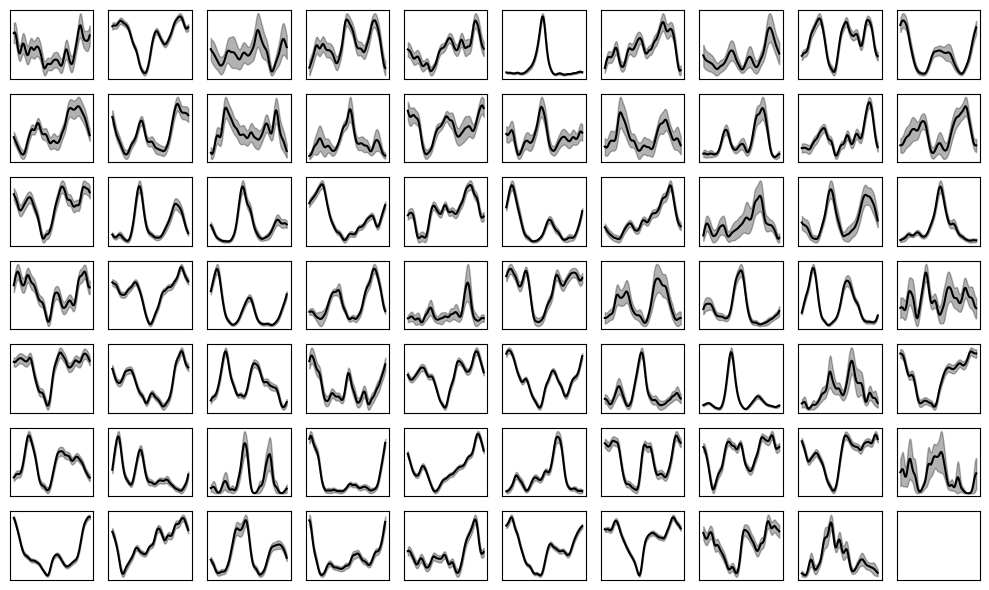

In [13]:
ncols = 10
nrows = int(np.ceil(len(avg_tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 2*(np.ceil(len(avg_tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(avg_tcs):
            index = neurons.index[counter]
            tc = avg_tcs[index]
            tc_sem = avg_tc_sems[index]
            ax[j, i].plot(np.arange(len(tc)), tc, color='black')
            ax[j, i].fill_between(np.arange(len(tc)), 
                                  tc-tc_sem,
                                  tc+tc_sem,
                                  color='black',
                                  alpha=0.3)
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()